In [ ]:
from os.path import join, isdir
from os import listdir, rmdir
from shutil import move, rmtree, make_archive

import os
import cv2
import glob
import pickle
import numpy as np
import tensorflow as tf

from PIL import Image
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Input, Dropout, Activation, Flatten, BatchNormalization, ReLU, LeakyReLU, concatenate
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D, AveragePooling2D, GlobalAveragePooling2D, Add

from google.colab import drive
drive.mount('/gdrive')
drive_root = '/gdrive/My Drive/Project/Semantic Segmentation/'

COLAB_DIR = '/content/'
GT_DIR = COLAB_DIR + 'gtFine/gtFine/'
IMG_DIR = COLAB_DIR + 'leftImg/leftImg8bit/'

Exception in thread Thread-5 (attachment_entry):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 237, in listen
    sock, _ = endpoints_listener.accept()
  File "/usr/lib/python3.10/socket.py", line 293, in accept
    fd, addr = self._accept()
TimeoutError: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/usr/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/local/lib/python3.10/dist-packages/google/colab/_debugpy.py", line 52, in attachment_entry
    debugpy.listen(_dap_port)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/public_api.py", line 31, in wrapper
    return wrapped(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/debugpy/server/api.py", line 143, in debug
    log.reraise

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
!pip install cityscapesscripts
from cityscapesscripts.download import downloader

#login on cityscapes website

session = downloader.login()
downloader.get_available_packages(session=session)

# downloading data
print('Downloading gtFine and leftImg8bit packages ...\n')
package_list =['gtFine_trainvaltest.zip', 'leftImg8bit_trainvaltest.zip']
downloader.download_packages(session=session, package_names=package_list, destination_path=COLAB_DIR)

Cityscapes username or email address: prathamahuja_23me205@dtu.ac.in
Cityscapes password: ··········
Store credentials unencrypted in '/root/.local/share/cityscapesscripts/credentials.json' [y/N]: y



Download progress: 100%|█████████▉| 241M/241M [00:08<00:00, 30.1MB/s]


Download progress:  98%|█████████▊| 10.8G/11.0G [06:08<00:06, 31.5MB/s]


In [ ]:
!unzip -q gtFine_trainvaltest.zip -d gtFine
!unzip -q leftImg8bit_trainvaltest.zip -d leftImg

In [ ]:
# collapse child directories
for parent in listdir(GT_DIR):
    parent_dir = GT_DIR + parent
    for child in listdir(parent_dir):
        if isdir(join(parent_dir, child)):
            keep = glob.glob(join(parent_dir, child) + '/*_gtFine_color.png')
            keep = [f.split('/')[-1] for f in keep]
            for filename in list(set(listdir(join(parent_dir, child))) & set(keep)):
                move(join(parent_dir, child, filename), join(parent_dir, filename))
            rmtree(join(parent_dir, child))

for parent in listdir(IMG_DIR):
    parent_dir = IMG_DIR + parent
    for child in listdir(parent_dir):
        if isdir(join(parent_dir, child)):
            for filename in listdir(join(parent_dir, child)):
                move(join(parent_dir, child, filename), join(parent_dir, filename))
            rmtree(join(parent_dir, child))

In [ ]:
# process and archive image in smaller size
IMG_SHAPE = 300,300

gt_train_paths = [GT_DIR+'train/' + path for path in listdir(GT_DIR+'train/')]
gt_test_paths = [GT_DIR+'test/' + path for path in listdir(GT_DIR+'test/')]
gt_val_paths = [GT_DIR+'val/' + path for path in listdir(GT_DIR+'val/')]
gt_paths = gt_train_paths + gt_test_paths + gt_val_paths

im_train_paths = [IMG_DIR+'train/' + path for path in listdir(IMG_DIR+'train/')]
im_test_paths = [IMG_DIR+'test/' + path for path in listdir(IMG_DIR+'test/')]
im_val_paths = [IMG_DIR+'val/' + path for path in listdir(IMG_DIR+'val/')]
im_paths = im_train_paths + im_test_paths + im_val_paths

def resize_image(path):
    img = Image.open(path)
    img.thumbnail(IMG_SHAPE)
    out_file = join(path)
    img.save(out_file, 'PNG')

for img in gt_paths + im_paths:
    resize_image(img)

make_archive('gtFine', 'zip', GT_DIR)
make_archive('leftImg', 'zip', IMG_DIR)

'/content/leftImg.zip'

In [ ]:
def download_if_missing(url, target, extract=True):
    if os.path.exists(target):
        return target
    return tf.keras.utils.get_file(target, origin=url, extract=extract)

gt_url_file = 'https://storage.googleapis.com/cityscapes_dataset/gtFine_trainvaltest.zip'
im_url_file = 'https://storage.googleapis.com/cityscapes_dataset/leftImg8bit_trainvaltest.zip'

gt_file, gt_dir = join(COLAB_DIR + 'gtFine.zip'), join(COLAB_DIR + 'gtFine/')
im_file, im_dir = join(COLAB_DIR + 'leftImg.zip'), join(COLAB_DIR + 'leftImg/')

download_if_missing(gt_url_file, gt_file, extract=False)
download_if_missing(im_url_file, im_file, extract=False)

!unzip -q $gt_file -d $gt_dir
!unzip -q $im_file -d $im_dir

In [ ]:
# normalize image pixels
IMG_SIZE = 299
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

GT_DIR = COLAB_DIR + 'gtFine/'
IMG_DIR = COLAB_DIR + 'leftImg/'

def load_and_preprocess_image(path):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_SIZE, IMG_SIZE])
    img /= 255.0
    return img

def get_image_paths(dir):
    return sorted([dir + path for path in listdir(dir)])

# create tf.Dataset objects
gt_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'train/'))
gt_val_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'val/'))
gt_test_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(GT_DIR+'test/'))

gt_train_ds = gt_train_ds.map(load_and_preprocess_image)
gt_val_ds = gt_val_ds.map(load_and_preprocess_image)
gt_test_ds = gt_test_ds.map(load_and_preprocess_image)

im_train_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'train/'))
im_val_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'val/'))
im_test_ds = tf.data.Dataset.from_tensor_slices(get_image_paths(IMG_DIR+'test/'))

im_train_ds = im_train_ds.map(load_and_preprocess_image)
im_val_ds = im_val_ds.map(load_and_preprocess_image)
im_test_ds = im_test_ds.map(load_and_preprocess_image)

In [ ]:
def visualize_images(img, gt, pred):
    if pred is not None:
        fig, axes = plt.subplots(1, 3, figsize=(12, 8))
    else:
        fig, axes = plt.subplots(1, 2, figsize=(8, 8))

    axes[0].imshow(img)
    axes[0].set_title('Actual Image')

    axes[1].imshow(gt)
    axes[1].set_title('Masked Image')

    if pred is not None:
        axes[2].imshow(pred)
        axes[2].set_title('Predicted Image')

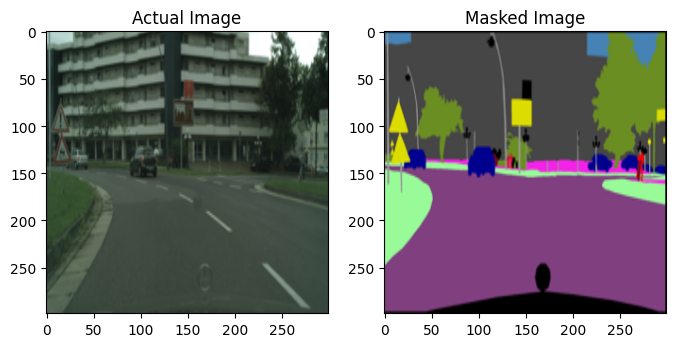

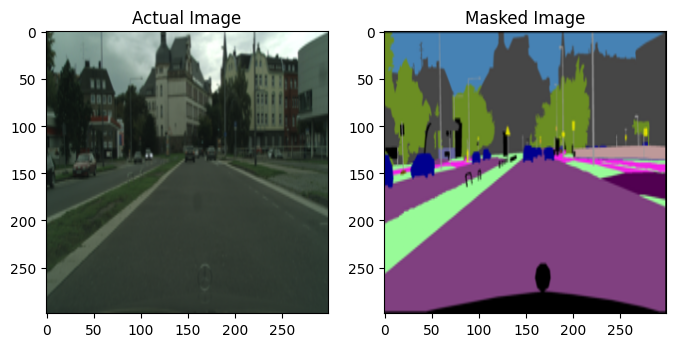

In [ ]:
for img, gt in list(zip(im_train_ds.take(2), gt_train_ds.take(2))):
    visualize_images(img, gt, None)

In [ ]:
def conv_block(X,filters,block):
    # resiudal block with dilated convolutions
    # add skip connection at last after doing convoluion

    b = 'block_'+str(block)+'_'
    f1,f2,f3 = filters
    X_skip = X

    # block_a
    X = Conv2D(filters=f1,kernel_size=(1,1),dilation_rate=(1,1),
               padding='same',kernel_initializer='he_normal',name=b+'a')(X)
    X = BatchNormalization(name=b+'batch_norm_a')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_a')(X)
    # block_b
    X = Conv2D(filters=f2,kernel_size=(3,3),dilation_rate=(2,2),
               padding='same',kernel_initializer='he_normal',name=b+'b')(X)
    X = BatchNormalization(name=b+'batch_norm_b')(X)
    X = LeakyReLU(alpha=0.2,name=b+'leakyrelu_b')(X)
    # block_c
    X = Conv2D(filters=f3,kernel_size=(1,1),dilation_rate=(1,1),
               padding='same',kernel_initializer='he_normal',name=b+'c')(X)
    X = BatchNormalization(name=b+'batch_norm_c')(X)
    # skip_conv
    X_skip = Conv2D(filters=f3,kernel_size=(3,3),padding='same',name=b+'skip_conv')(X_skip)
    X_skip = BatchNormalization(name=b+'batch_norm_skip_conv')(X_skip)
    # block_c + skip_conv
    X = Add(name=b+'add')([X,X_skip])
    X = ReLU(name=b+'relu')(X)
    return X

def base_feature_maps(input_layer):
    # base covolution module to get input image feature maps

    # block_1
    base = conv_block(input_layer,[16,16,32],'1')
    # block_2
    base = conv_block(base,[16,16,32],'2')
    return base

def pyramid_feature_maps(input_layer):
    # pyramid pooling module

    base = base_feature_maps(input_layer)
    # red
    red = GlobalAveragePooling2D(name='red_pool')(base)
    red = tf.keras.layers.Reshape((1,1,32))(red)
    red = Conv2D(filters=32,kernel_size=(1,1),name='red_1_by_1')(red)
    red = UpSampling2D(size=128,interpolation='bilinear',name='red_upsampling')(red)
    red = tf.image.resize(red, [IMG_SIZE, IMG_SIZE])
    # yellow
    yellow = AveragePooling2D(pool_size=(2,2),name='yellow_pool')(base)
    yellow = Conv2D(filters=32,kernel_size=(1,1),name='yellow_1_by_1')(yellow)
    yellow = UpSampling2D(size=2,interpolation='bilinear',name='yellow_upsampling')(yellow)
    yellow = tf.image.resize(yellow, [IMG_SIZE, IMG_SIZE])
    # blue
    blue = AveragePooling2D(pool_size=(4,4),name='blue_pool')(base)
    blue = Conv2D(filters=32,kernel_size=(1,1),name='blue_1_by_1')(blue)
    blue = UpSampling2D(size=4,interpolation='bilinear',name='blue_upsampling')(blue)
    blue = tf.image.resize(blue, [IMG_SIZE, IMG_SIZE])
    # green
    green = AveragePooling2D(pool_size=(8,8),name='green_pool')(base)
    green = Conv2D(filters=32,kernel_size=(1,1),name='green_1_by_1')(green)
    green = UpSampling2D(size=8,interpolation='bilinear',name='green_upsampling')(green)
    green = tf.image.resize(green, [IMG_SIZE, IMG_SIZE])
    # base + red + yellow + blue + green
    return tf.keras.layers.concatenate([base,red,yellow,blue,green])

def last_conv_module(input_layer):
    X = pyramid_feature_maps(input_layer)
    X = Conv2D(filters=3,kernel_size=3,padding='same',name='last_conv_3_by_3')(X)
    X = BatchNormalization(name='last_conv_3_by_3_batch_norm')(X)
    X = Activation('sigmoid',name='last_conv_relu')(X)
    return X

In [ ]:
input_shape = list(im_train_ds.take(1))[0].shape
input_layer = tf.keras.Input(shape=input_shape, name='input')
output_layer = last_conv_module(input_layer)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 block_1_a (Conv2D)          (None, 299, 299, 16)         64        ['input[0][0]']               
                                                                                                  
 block_1_batch_norm_a (Batc  (None, 299, 299, 16)         64        ['block_1_a[0][0]']           
 hNormalization)                                                                                  
                                                                                                  
 block_1_leakyrelu_a (Leaky  (None, 299, 299, 16)         0         ['block_1_batch_norm_a[0][

In [ ]:
train_ds = tf.data.Dataset.zip((im_train_ds, gt_train_ds))
train_ds = train_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

val_ds = tf.data.Dataset.zip((im_val_ds, gt_val_ds))
val_ds = val_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

test_ds = tf.data.Dataset.zip((im_test_ds, gt_test_ds))
test_ds = test_ds.cache().batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

In [ ]:
from tensorflow.keras.callbacks import TensorBoard

tensorboard=TensorBoard(log_dir=drive_root+'logs/')

In [ ]:
checkpoint_path = drive_root+'pspnet/cp.ckpt'
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
es_callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=2)

model.compile(optimizer='adam', loss='mse', metrics='accuracy')
history = model.fit(train_ds, validation_data=val_ds, epochs=5,
                    callbacks=[cp_callback, es_callback])
model.save(drive_root + 'PSPNet_semantic_segmentation_5.h5')

In [ ]:
def plot(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1,len(acc)+1)

  plt.title('Training and validation accuracy')
  plt.plot(epochs, acc, color='blue', label='Train')
  plt.plot(epochs, val_acc, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend()

  _ = plt.figure()
  plt.title('Training and validation loss')
  plt.plot(epochs, loss, color='blue', label='Train')
  plt.plot(epochs, val_loss, color='orange', label='Val')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend()

plot(history)

In [ ]:
pred_test_ds = model.predict(train_ds)

for img, gt, pred in list(zip(im_train_ds.take(5), gt_train_ds.take(5), pred_test_ds)):
    visualize_images(img, gt, pred)